In [9]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import randint as sp_randint

warnings.filterwarnings('ignore')
random_state = 27

# Load the data

In [104]:
%run ../util/load_data.py
%run ../util/data_visualization.py
%run ../util/outliers_statistics.py

data = load_data("../../Data", False)
X = data['train_data'][data['numerical_attributes'] + data['categorical_attributes']]
y = data['train_data'][data['target']]

# Build classifier with params for grid search

In [7]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [111]:
estimator = Pipeline([
    ('scl', StandardScaler()),
    ('clf', KNeighborsClassifier(n_jobs=4, algorithm='kd_tree', weights='distance'))
])
hyperparameters = {
        'clf__n_neighbors': np.logspace(1, 5, 10, base=2).astype('int64'),
        'clf__leaf_size': np.logspace(1, 12, 20, base=2).astype('int64'),
        'clf__p': [1, 2]
    }
k = StratifiedKFold(n_splits=5)

In [113]:
classifier = RandomizedSearchCV(n_iter=20, estimator=estimator, param_distributions=hyperparameters, cv=k, scoring="accuracy", verbose=2, n_jobs=8)
with ignore_warnings(category=ConvergenceWarning):
    classifier.fit(X, np.ravel(y))
report(classifier.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  6.5min finished


Model with rank: 1
Mean validation score: 0.728 (std: 0.040)
Parameters: {'clf__p': 1, 'clf__n_neighbors': 2, 'clf__leaf_size': 368}

Model with rank: 1
Mean validation score: 0.728 (std: 0.040)
Parameters: {'clf__p': 1, 'clf__n_neighbors': 2, 'clf__leaf_size': 49}

Model with rank: 1
Mean validation score: 0.728 (std: 0.040)
Parameters: {'clf__p': 1, 'clf__n_neighbors': 2, 'clf__leaf_size': 9}

Model with rank: 1
Mean validation score: 0.728 (std: 0.040)
Parameters: {'clf__p': 1, 'clf__n_neighbors': 2, 'clf__leaf_size': 74}

Model with rank: 1
Mean validation score: 0.728 (std: 0.040)
Parameters: {'clf__p': 1, 'clf__n_neighbors': 2, 'clf__leaf_size': 9}



In [114]:
classifier.best_score_

0.7276455026455027

In [121]:
classifier.best_params_

{'clf__p': 1, 'clf__n_neighbors': 2, 'clf__leaf_size': 368}

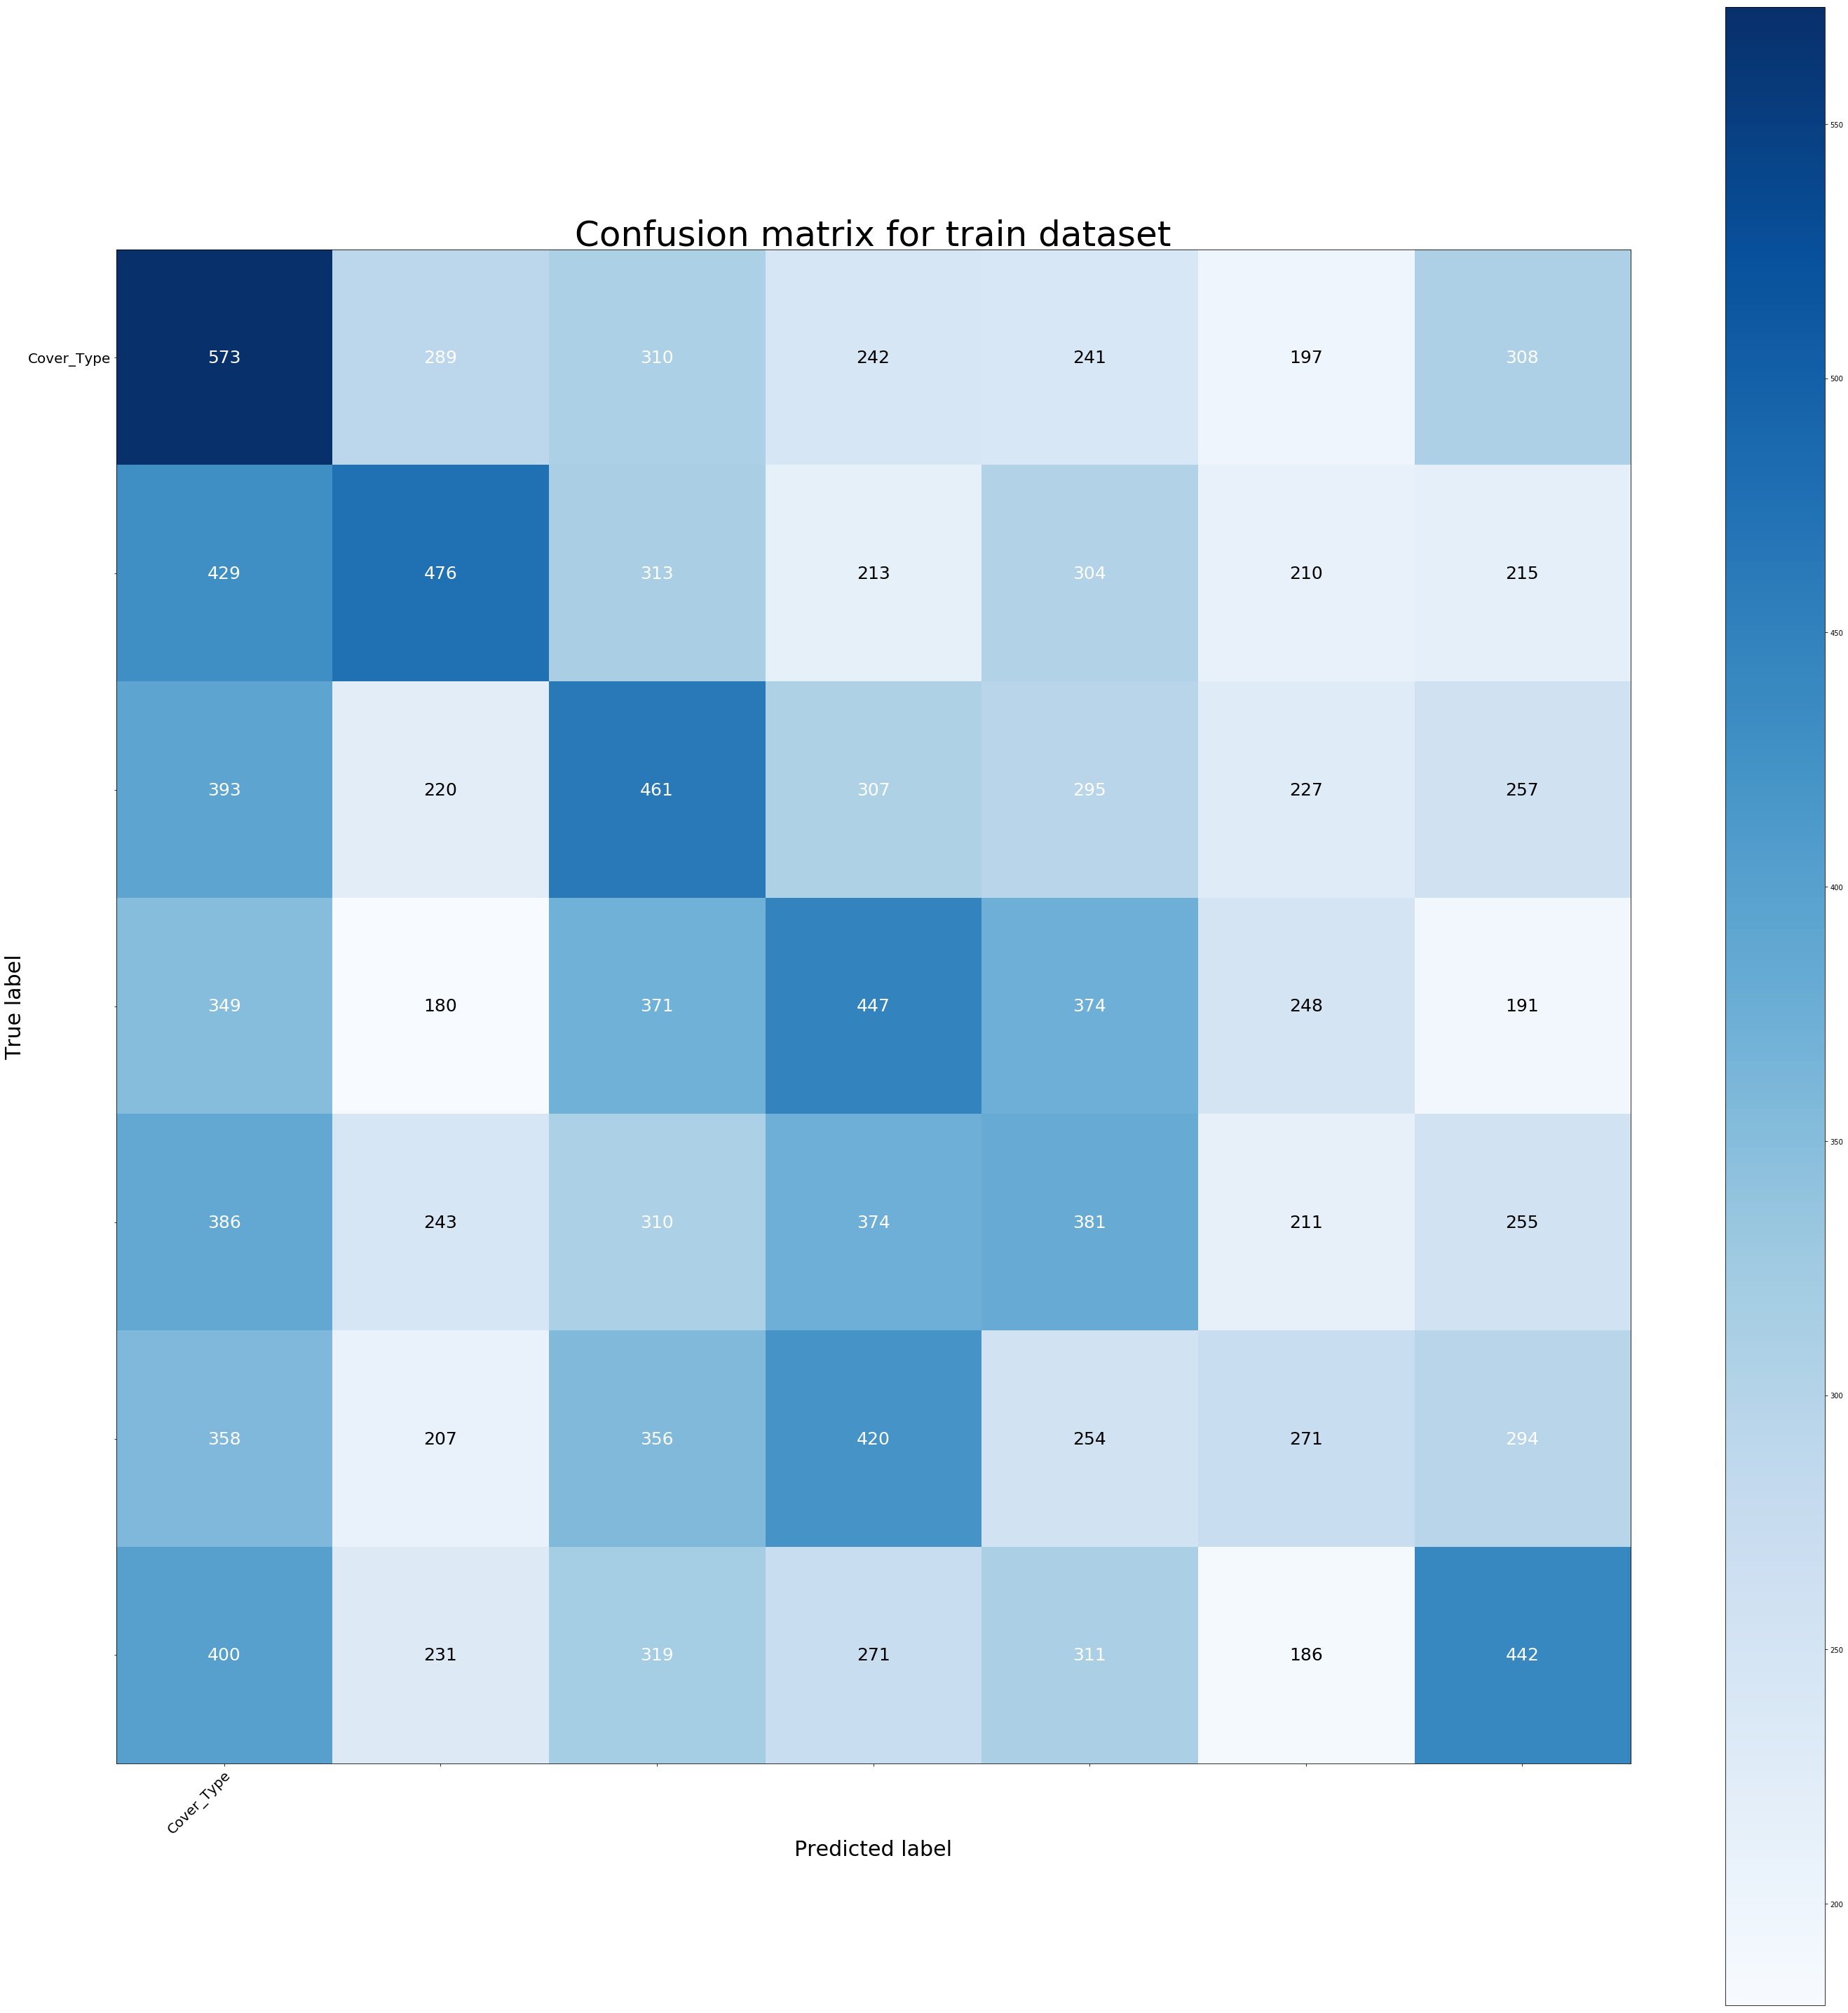

In [120]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

y_predicted_total = []

estimator.set_params(**classifier.best_params_)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_classifier.fit(X_train, y_train)
    
    y_predicted_total += best_classifier.predict(X_test).tolist()
    
plot_confusion_matrix(y, y_predicted_total, classes=list(set(y[data['target']])),
                  title='Confusion matrix for train dataset')